# InfoGAN
*Please note that this is an optional notebook meant to introduce more advanced concepts. If you’re up for a challenge, take a look and don’t worry if you can’t follow everything. There is no code to implement—only some cool code for you to learn and run!*

### Carregamento e Pré-processamento dos Dados

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import os
import pandas as pd
import numpy as np
from PIL import Image

In [3]:
################  ONLY NECESSARY TO USE THE FIRST TIME WHEN THIS NOTEBOOK IS USED  #########################
# Dataset
trainval_folder = 'train/PRPD_dataset/TrainVal'
test_folder = 'train/PRPD_dataset/Test'

def get_dataset(path, split=''):
    images_path = []
    for dirpath, dirnames, files in os.walk(path):
        for file in files:
            path = os.path.join(dirpath, file)
            motor = os.path.basename(dirpath)
            defect = os.path.basename(os.path.dirname(dirpath))
            images_path.append((path, motor, defect, split))
    return images_path

trainval_path = os.path.join(os.path.dirname(os.getcwd()), trainval_folder)
test_path = os.path.join(os.path.dirname(os.getcwd()), test_folder)

classes = os.listdir(trainval_path)
print('Defects: {}'.format(classes))

trainval_ds = get_dataset(trainval_path, split='Train-val')
test_df = get_dataset(test_path, split='Test')

# Create pandas dataframe
df = pd.DataFrame(trainval_ds+test_df, columns=['Filename', 'Motor', 'Defect', 'Split'])
df['Class'], unique_labels = pd.factorize(df['Defect'])

Defects: ['internal', 'surface', 'corona']


In [4]:
class ImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df
        self.filenames = self.df['Filename'].values
        self.labels = self.df['Class'].values
        self.images = np.zeros((len(self.labels), 256, 256, 3), dtype= np.uint8)
        self.transform = transform
        self.getImages()

    def getImages(self):
        for idx, filename in enumerate(self.filenames):
            img = Image.open(filename)  # Abre a imagem
            img = img.convert('RGB')  # Converte para RGB
            img = img.resize((256, 256), Image.Resampling.LANCZOS)  # Redimensiona a imagem

            # Converte a imagem para um array numpy (opcional, se necessário)
            self.images[idx] = np.array(img)

    def toTensor(self, data):
        image = data.transpose((2,0,1))
        return torch.from_numpy(image)

    def normalize(self, image_arr):
        return (image_arr - image_arr.min()) / (image_arr.max() - image_arr.min())
    
    def __getitem__(self, idx):
        x = self.images[idx]
        x = self.toTensor(x)
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x,y

    def __len__(self):
        return len(self.filenames)

In [5]:
transform = transforms.Compose([transforms.ToDtype(torch.float32, scale=True),
                                    transforms.RandomRotation(degrees=(0,25)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.5),
                                    transforms.GaussianBlur(kernel_size=(3,3)),
                                    transforms.RandomAdjustSharpness(sharpness_factor=1.33),
                                    transforms.Resize((256,256))])
dataset = ImageDataset(df, transform=transform)
batch_size = 32
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [6]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 256, 256]) torch.Size([32])


In [7]:
if torch.cuda.is_available():
    print("CUDA is available! You can use GPU.")
    device = torch.device("cuda")
    print(f"Device: {torch.cuda.get_device_name(device)}")
    cuda = True
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")
    cuda = False

CUDA is available! You can use GPU.
Device: Tesla V100-SXM2-16GB


Dessa célula em diante, este notebook foi retirado do Coursera, do curso **Build Basic Generative Adversarial Networks (GANs)**. Foram feitas apenas adaptações para a base de dados que o grupo irá trabalhar.

### Goals

In this notebook, you're going to learn about InfoGAN in order to generate disentangled outputs, based on the paper, [InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets](https://arxiv.org/abs/1606.03657) by Chen et. al. While there are many approaches to disentanglement, this is one of the more widely used and better known. 

InfoGAN can be understood like this: you want to separate your model into two parts: $z$, corresponding to truly random noise, and $c$ corresponding to the "latent code." The latent code $c$ which can be thought of as a "hidden" condition in a conditional generator, and you'd like it to have an interpretable meaning. 

Now, you'll likely immediately wonder, how do they get $c$, which is just some random set of numbers, to be more interpretable than any dimension in a typical GAN? The answer is "mutual information": essentially, you would like each dimension of the latent code to be as obvious a function as possible of the generated images. Read on for a more thorough theoretical and practical treatment.

### Formally: Variational Lower Bound
The [information entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) ${H} (X)=-\sum _{i=1}^{n}{P(x_{i})\log P (x_{i})}$
can be understood to the amount of "information" in the distribution $X$. For example, the information entropy of $n$ fair coins is $n$ bits. You've also seen a similar equation before: the cross-entropy loss. Moreover, mutual information $I(X;Y) = H(X) - H(X\vert Y)$, which the authors of InfoGAN describe as (intuitively) the "reduction of uncertainty in $X$ when $Y$ is observed." 

In InfoGAN, you'd like to maximize $I(c; G(z, c))$, the mutual information between the latent code $c$ and the generated images $G(z, c)$.  Since it's difficult to know $P(c | G(z, c))$, you add a second output to the discriminator to predict $P(c | G(z, c))$. 

Let $\Delta = D_{KL}(P(\cdot|x) \Vert Q(\cdot|x))$, the [Kullback-Leibler_divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the true and approximate distribution. Then, based on Equation 4 in the paper, the mutual information has the following lower bound: 
$$\begin{split}
I(c; G(z, c)) & = H(c) - H(c|G(z, c)) \\
& = {\mathbb{E}}_{x \sim G(z, c)} [ {\mathbb{E}}_{c' \sim P(c, x)} \log P(c' | x) ] + H(c) \textit{ (by definition of H)}\\
& = {\mathbb{E}}_{x \sim G(z, c)} [\Delta + {\mathbb{E}}_{c' \sim P(c, x)} \log Q(c' | x) ] + H(c) \textit{ (approximation error)}\\
& \geq {\mathbb{E}}_{x \sim G(z, c)} [{\mathbb{E}}_{c' \sim P(c, x)} \log Q(c' | x) ] + H(c) \textit{ (KL divergence is non-negative)}\\
\end{split}
$$

For a given latent code distribution, $H(c)$ is fixed, so the following makes a good loss:

$${\mathbb{E}}_{x \sim G(z, c)} [{\mathbb{E}}_{c' \sim P(c, x)} \log Q(c' | x) ]$$

Which is the mean cross entropy loss of the approximation over the generator's images. 

### Updating the Minimax Game

A vanilla generator and discriminator follow a minimax game: $\displaystyle \min_{G} \max_{D} V(D, G) = \mathbb{E}(\log D(x)) + \mathbb{E}(\log (1 - D(G(z))))$.

To encourage mutual information, this game is updated for $Q$ to maximize mutual information: $\displaystyle \min_{G, Q} \max_{D} V(D, G) - \lambda I(c; G(z, c))$

## Implementing InfoGAN

For this notebook, you'll be using the MNIST dataset again. 

You will begin by importing the necessary libraries and building the generator and discriminator. The generator will be the same as before, but the discriminator will be modified with more dimensions in its output.

#### Packages and Visualization

In [8]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

#### Generator and Noise

In [9]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=100, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
  
        self.gen1 = self.make_gen_block(input_dim, hidden_dim * 16)  # 1x1 -> 4x4
        self.gen2 = self.make_gen_block(hidden_dim * 16, hidden_dim * 8, kernel_size=4, stride=2, padding=1)  # 4x4 -> 8x8
        self.gen3 = self.make_gen_block(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2, padding=1)   # 8x8 -> 16x16
        self.gen4 = self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1)   # 16x16 -> 32x32
        self.gen5 = self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1)       # 32x32 -> 64x64
        self.gen6 = self.make_gen_block(hidden_dim, hidden_dim // 2, kernel_size=4, stride=2, padding=1)      # 64x64 -> 128x128
        self.gen7 = self.make_gen_block(hidden_dim // 2, hidden_dim // 4, kernel_size=4, stride=2, padding=1) # 128x128 -> 256x256
        
        # Extra convolução para ajustar para próximo de 440x440
        self.extra = nn.ConvTranspose2d(hidden_dim // 4, im_chan, kernel_size=4, stride=2, padding=1)  # 256x256 -> ~510x510
        #self.final = nn.ConvTranspose2d(hidden_dim // 8, im_chan, kernel_size=3, stride=1, padding=1)  # Ajuste final para ~440x440
        
        # Função de ativação final (Tanh) para normalizar a saída entre -1 e 1
        #self.tanh = nn.Tanh()

    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1):
        '''
        Função para criar um bloco gerador com convolução transposta, batchnorm e ReLU.
        '''
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        #print(f"Input noise reshaped: {x.shape}")
        
        x = self.gen1(x)
        #print(f"After gen1: {x.shape}")
        
        x = self.gen2(x)
        #print(f"After gen2: {x.shape}")
        
        x = self.gen3(x)
        #print(f"After gen3: {x.shape}")
        
        x = self.gen4(x)
        #print(f"After gen4: {x.shape}")
        
        x = self.gen5(x)
        #print(f"After gen5: {x.shape}")
        
        x = self.gen6(x)
        #print(f"After gen6: {x.shape}")
        
        x = self.gen7(x)
        #print(f"After gen7: {x.shape}")
        
        x = self.extra(x)  # Camada ajustada para expandir mais
        #print(f"After extra: {x.shape}")
        
        #x = self.final(x)  # Ajuste final
        #print(f"After final: {x.shape}")
        
        #x = self.tanh(x)
        #print(f"After Tanh: {x.shape}")
      
        return x

def get_noise(n_samples, input_dim, device='cuda'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

#### InfoGAN Discriminator

You update the final layer to predict a distribution for $c$ from $x$, alongside the traditional discriminator output. Since you're assuming a normal prior in this assignment, you output a mean and a log-variance prediction.

In [10]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
      c_dim: the number of latent code dimensions - 
    '''
    def __init__(self, im_chan=3, hidden_dim=64, c_dim=10):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),            # 256x256 -> 128x128
            self.make_disc_block(hidden_dim, hidden_dim * 2),     # 128x128 -> 64x64
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4), # 64x64 -> 32x32
            self.make_disc_block(hidden_dim * 4, hidden_dim * 8), # 32x32 -> 16x16
            self.make_disc_block(hidden_dim * 8, hidden_dim * 16),# 16x16 -> 8x8
            self.make_disc_block(hidden_dim * 16, hidden_dim * 32),# 8x8 -> 4x4
        )
        
        # Classificador binário (real/fake)
        self.d_layer = nn.Sequential(
            self.make_disc_block(hidden_dim * 32, 1, kernel_size=4, stride=1, final_layer=True),  # Reduz 4x4 -> 1
        )
        
        # Rede Q para inferir as variáveis latentes
        self.q_layer = nn.Sequential(
            self.make_disc_block(hidden_dim * 32, hidden_dim * 16, kernel_size=1, stride=1),  # 6x6 -> 6x6
            nn.Conv2d(hidden_dim * 16, 2 * c_dim, kernel_size=6, stride=1)  # Tente alterar para kernel_size=3 ou 4 se a saída não for a esperada
        )


    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has (should be 3 for RGB in the first layer)
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
    
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding=1),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        intermediate_pred = self.disc(image)
        disc_pred = self.d_layer(intermediate_pred)
        q_pred = self.q_layer(intermediate_pred)
        return disc_pred.view(len(disc_pred), -1), q_pred.view(len(q_pred), -1)


## Helper Functions

You can include some helper functions for conditional GANs:

In [11]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        This will be the noise vector of shape (n_samples, z_dim).
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes).
    '''
    combined = torch.cat([x.float(), y.float()], 1)
    combined = combined.view(combined.shape[0], -1, 1, 1)
    return combined

## Training

Let's include the same parameters from previous assignments, as well as a new `c_dim` dimension for the dimensionality of the InfoGAN latent code, a `c_criterion`, and its corresponding constant, `c_lambda`:

  *   prpd_shape: the number of pixels in each MNIST image, which has dimensions 28 x 28 and one channel (because it's black-and-white) so 1 x 28 x 28
  *   adv_criterion: the vanilla GAN loss function
  *   c_criterion: the additional mutual information term
  *   c_lambda: the weight on the c_criterion
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   c_dim: the dimension of the InfoGAN latent code
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type


In [19]:
from torch.distributions.normal import Normal
adv_criterion = nn.BCEWithLogitsLoss()
c_criterion = lambda c_true, mean, logvar: Normal(mean, logvar.exp()).log_prob(c_true).mean()
c_lambda = 0.1
prpd_shape = (1, 440, 440)
n_epochs = 100
z_dim = 56
c_dim = 10
display_step = 500
# batch_size = 128
# # InfoGAN uses two different learning rates for the models
d_lr = 2e-4
g_lr = 1e-3
device = 'cuda'

You initialize your networks as usual - notice that there is no separate $Q$ network. There are a few "design" choices worth noting here: 
1. There are many possible choices for the distribution over the latent code. You use a Gaussian prior here, but a categorical (discrete) prior is also possible, and in fact it's possible to use them together. In this case, it's also possible to use different weights $\lambda$ on both prior distributions. 
2. You can calculate the mutual information explicitly, including $H(c)$ which you treat as constant here. You don't do that here since you're not comparing the mutual information of different parameterizations of the latent code.
3. There are multiple ways to handle the $Q$ network - this code follows the original paper by treating it as part of the discriminator, sharing most weights, but it is also possible to simply initialize another network.

In [20]:
gen = Generator(input_dim=z_dim + c_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=g_lr)
disc = Discriminator(im_chan=3, c_dim=c_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=d_lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Now let's get to training the networks:

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 16, step 500: Generator loss: 6.432570854187012, discriminator loss: 0.19080251482129096


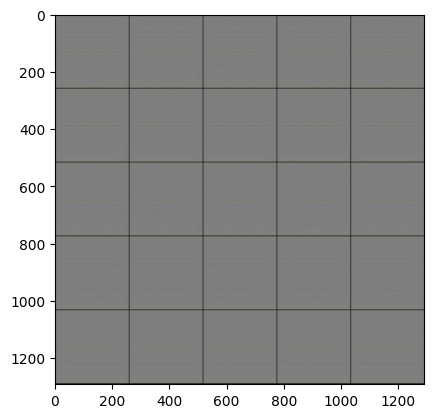

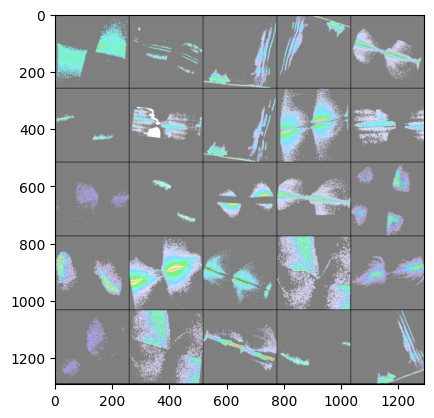

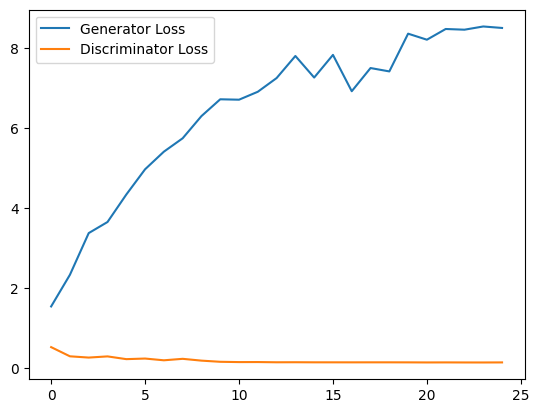

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 33, step 1000: Generator loss: 6.413799273967743, discriminator loss: 0.24249604865908622


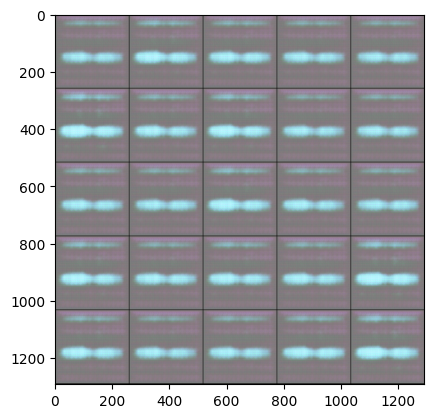

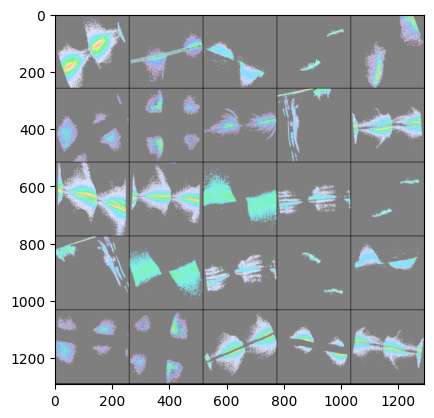

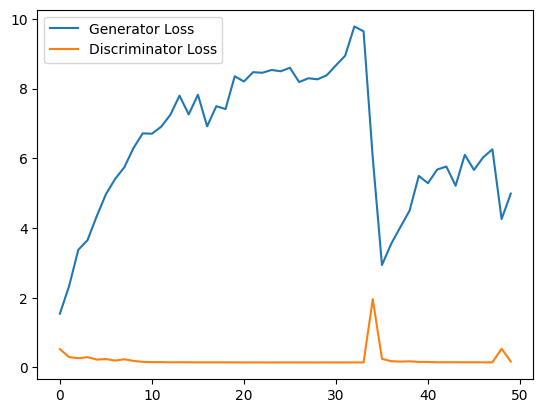

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 50, step 1500: Generator loss: 5.904714966952801, discriminator loss: 0.1900115555524826


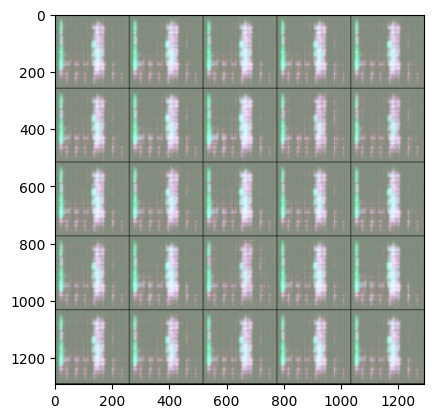

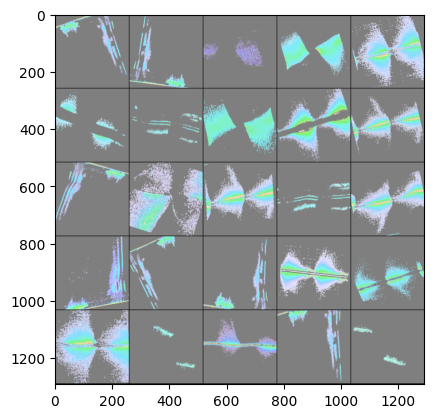

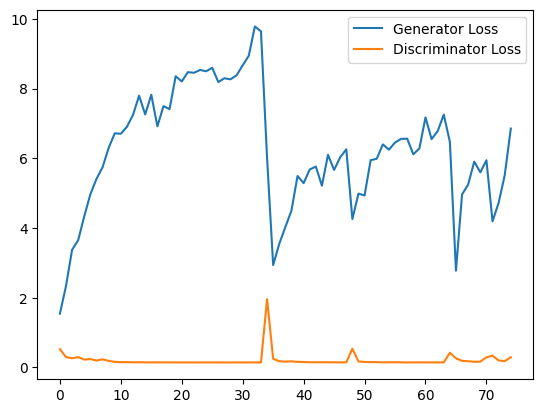

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 66, step 2000: Generator loss: 5.8030431733131405, discriminator loss: 0.24948049631714822


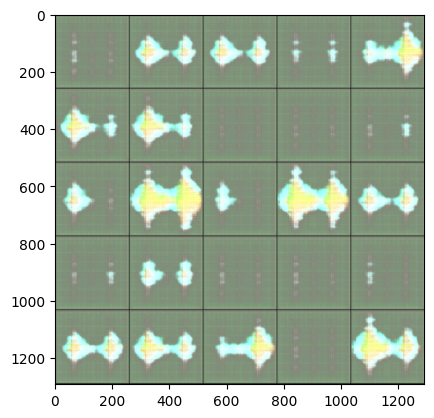

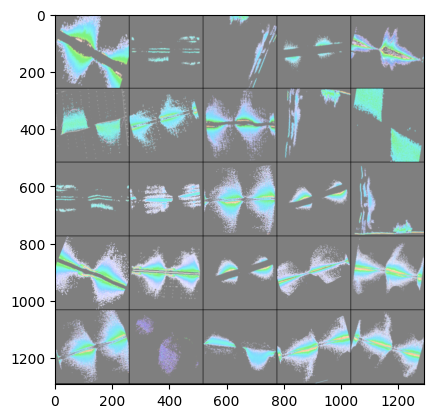

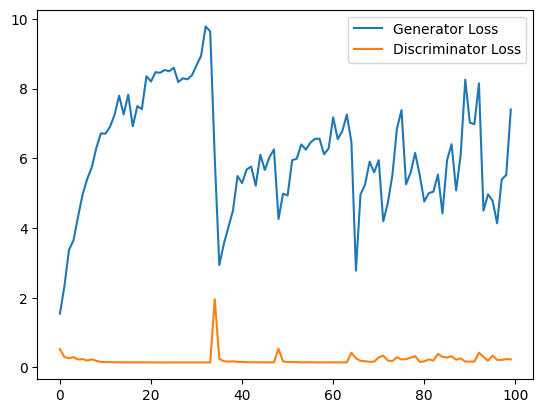

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 83, step 2500: Generator loss: 5.53848841547966, discriminator loss: 0.23181643962860107


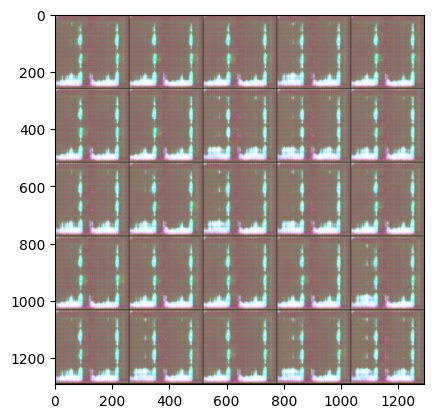

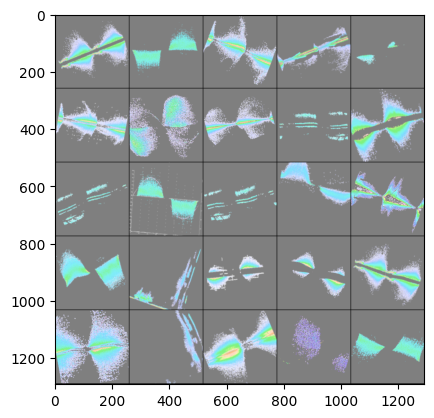

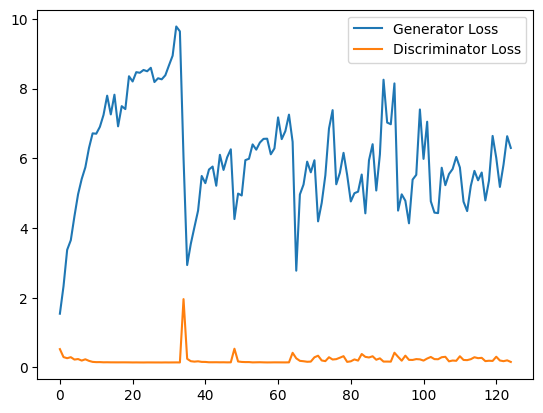

In [21]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in tqdm(range(n_epochs)):
    # Dataloader returns the batches and the labels
    for real, _ in (train_loader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        c_labels = get_noise(cur_batch_size, c_dim, device=device)    
        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        # Combine the noise vectors and the one-hot labels for the generator
        noise_and_labels = combine_vectors(fake_noise, c_labels)
        # Generate the conditioned fake images
        fake = gen(noise_and_labels)
        #print(f"Tamanho da imagem fake: {fake.shape}")
        
        # Get the discriminator's predictions
        disc_fake_pred, disc_q_pred = disc(fake.detach())
        disc_q_mean = disc_q_pred[:, :c_dim]
        disc_q_logvar = disc_q_pred[:, c_dim:]
        mutual_information = c_criterion(c_labels, disc_q_mean, disc_q_logvar)
        disc_real_pred, _ = disc(real)
        disc_fake_loss = adv_criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = adv_criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2 - c_lambda * mutual_information
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        disc_fake_pred, disc_q_pred = disc(fake)
        disc_q_mean = disc_q_pred[:, :c_dim]
        disc_q_logvar = disc_q_pred[:, c_dim:]
        mutual_information = c_criterion(c_labels, disc_q_mean, disc_q_logvar)
        gen_loss = adv_criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) - c_lambda * mutual_information
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1

## Exploration
You can do a bit of exploration now!

In [ ]:
# Before you explore, you should put the generator
# in eval mode, both in general and so that batch norm
# doesn't cause you issues and is using its eval statistics
gen = gen.eval()

#### Changing the Latent Code Vector
You can generate some numbers with your new model! You can add interpolation as well to make it more interesting.

So starting from a image, you will produce intermediate images that look more and more like the ending image until you get to the final image. Your're basically morphing one image into another. You can choose what these two images will be using your conditional GAN.

In [ ]:
import math

### Change me! ###
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)

def interpolate_class(n_view=5):
    # Gera o ruído no dispositivo correto
    interpolation_noise = get_noise(n_view, z_dim, device=device).repeat(n_interpolation, 1)
    
    # Gera os primeiros e segundos rótulos no mesmo dispositivo
    first_label = get_noise(1, c_dim, device=device).repeat(n_view, 1)[None, :]
    second_label = first_label.clone().to(device)  # Garantir que também está no dispositivo correto
    
    # Ajusta os valores dos rótulos
    first_label[:, :, 0] = -2
    second_label[:, :, 0] = 2
    
    # Vetor de interpolação entre os dois rótulos
    percent_second_label = torch.linspace(0, 1, n_interpolation, device=device)[:, None, None]  # Certificar que está no mesmo dispositivo
    
    # Interpolação entre os rótulos
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label
    interpolation_labels = interpolation_labels.view(-1, c_dim)
    
    # Combina o ruído e os rótulos
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    
    # Mostra as imagens geradas
    show_tensor_images(fake, num_images=n_interpolation * n_view, nrow=n_view, show=False)

# Chama a função de interpolação
plt.figure(figsize=(8, 8))
interpolate_class()
_ = plt.axis('off')



You can also visualize the impact of pairwise changes of the latent code for a given noise vector.

In [ ]:
import math

### Change me! ###
n_interpolation = 8 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)

def interpolate_class():
    interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation * n_interpolation, 1)
    first_label = get_noise(1, c_dim).repeat(n_interpolation * n_interpolation, 1)
    
    # Calculate the interpolation vector between the two labels
    first_label = torch.linspace(-2, 2, n_interpolation).repeat(n_interpolation)
    second_label = torch.linspace(-2, 2, n_interpolation).repeat_interleave(n_interpolation)
    interpolation_labels = torch.stack([first_label, second_label], dim=1) 

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation * n_interpolation, nrow=n_interpolation, show=False)

plt.figure(figsize=(8, 8))
interpolate_class()
_ = plt.axis('off')
